In [6]:
from IPython.display import display, HTML

display(HTML(r"""
<style>
/* JupyterLab 4.x: center the notebook area */
.jp-NotebookPanel-notebook,
.jp-NotebookPanel .jp-Notebook {
  width: 85% !important;
  max-width: 1100px !important;
  margin: 0 auto !important;
}

/* Make wide outputs scroll instead of breaking the layout */
.jp-OutputArea-output {
  overflow-x: auto !important;
}
</style>
"""))

%config InlineBackend.figure_format = "svg"
print("Centered JupyterLab notebook + SVG inline figures.")

Centered JupyterLab notebook + SVG inline figures.


<a id="0"></a> <br>
## Table of Contents
- [1. Ngrams](#00)
  - [0.1 Install Anaconda and setup environment](#01)
  - [0.2 Checking your device](#02)

## 1. Statistical Language Models

Statistical language models

In [11]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<a id="11"></a>
## 1.1 Build ngram LM based on kenlm

- **Load wikitext-103**

In [25]:
import io
from datasets import load_dataset

wiki103_ds = load_dataset("Salesforce/wikitext", "wikitext-103-raw-v1")
out_path_train = "wikitext103_raw_train.txt"
out_path_test = "wikitext103_raw_test.txt"
with io.open(out_path_train, "w", encoding="utf-8") as f:
    for ex in wiki103_ds["train"]:
        line = ex["text"].replace("\n", " ").strip()
        if line: # skip blank lines
            f.write(line + "\n")
print("Wrote:", out_path_train)

with io.open(out_path_test, "w", encoding="utf-8") as f:
    for ex in wiki103_ds["test"]:
        line = ex["text"].replace("\n", " ").strip()
        if line: # skip blank lines
            f.write(line + "\n")
print("Wrote:", out_path_test)


Wrote: wikitext103_raw_train.txt
Wrote: wikitext103_raw_test.txt


- **Use BPE tokenization**

- **Encode into a KenLM corpus: space-separated BPE tokens**

In [50]:
# train_light_bpe.py
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import BertPreTokenizer
from tokenizers.normalizers import NFKC

tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.normalizer = NFKC()
tokenizer.pre_tokenizer = BertPreTokenizer()  # splits words & punctuation

trainer = BpeTrainer(
    vocab_size=10_000,          # bigger => fewer splits (lighter)
    min_frequency=10,             # higher => fewer splits
    special_tokens=["[UNK]"],    # avoid <s>, </s>, <unk> strings for kenlm
    continuing_subword_prefix="##"  # makes splits recoverable
)

tokenizer.train(["wikitext103_raw_train.txt", "wikitext103_raw_test.txt"], trainer)
tokenizer.save("wikitext103_bpe_tokenizer.json")
print("saved tokenizer.json")




saved tokenizer.json


- **Format and filter dataset into kenlm text corpus**

In [51]:
def bpe_tokenize(in_path, out_path):
    FORBIDDEN = {"<s>", "</s>", "<unk>"}
    REPLACE = {"<s>": "[BOS]", "</s>": "[EOS]", "<unk>": "[UNK]"}  # safe substitutes
    with io.open(in_path, "r", encoding="utf-8", errors="ignore") as fin, \
         io.open(out_path, "w", encoding="utf-8") as fout:
        for line in fin:
            line = line.rstrip("\n")
            if not line.strip():
                fout.write("\n")
                continue
            enc = tok.encode(line)
            tokens = enc.tokens
            tokens = [REPLACE.get(t, t) for t in tokens]
            fout.write(" ".join(tokens) + "\n")
    
    print("Wrote:", out_path)

In [ ]:
import io
from tokenizers import Tokenizer
tok = Tokenizer.from_file("wikitext103_bpe_tokenizer.json")

bpe_tokenize(in_path= "wikitext103_raw_train.txt", 
             out_path= "wikitext103_raw_train_bpe-kenlm.txt")
bpe_tokenize(in_path= "wikitext103_raw_test.txt", 
             out_path= "wikitext103_raw_test_bpe-kenlm.txt")

In [10]:
!/Users/baojianzhou/git/kenlm/build/bin/lmplz -o 2 --text wikitext103_raw_train_bpe-kenlm.txt --arpa wikitext103_o2.arpa

=== 1/5 Counting and sorting n-grams ===
Reading fd 3
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Unigram tokens 112805831 types 48067
=== 2/5 Calculating and sorting adjusted counts ===
Chain sizes: 1:576804 2:15461305344
Statistics:
1 48067 D1=0.519655 D2=0.996578 D3+=1.50348
2 9415480 D1=0.654283 D2=1.10341 D3+=1.44008
Memory estimate for binary LM:
type     MB
probing 162 assuming -p 1.5
probing 163 assuming -r models -p 1.5
trie     53 without quantization
trie     28 assuming -q 8 -b 8 quantization 
trie     53 assuming -a 22 array pointer compression
trie     28 assuming -a 22 -q 8 -b 8 array pointer compression and quantization
=== 3/5 Calculating and sorting initial probabilities ===
Chain sizes: 1:576804 2:150647680
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
#####

In [11]:
def calculate_perplexity(test_sents, model):
    tokens = 0
    sum_log10_prob = 0.
    for sent in test_sents:
        log10_prob = model.score(sent, bos=True, eos=True)
        tokens += len(sent.split())  + 1 # 1 means </s>
        sum_log10_prob += log10_prob
    # Calculate the perplexity: 10 ** (-log10_prob / N)
    perplexity = 10.0 ** (-sum_log10_prob/tokens)
    return perplexity

In [15]:
import kenlm

bigram_model = kenlm.Model('wikitext103_o2.arpa')
print(bigram_model.score('this is a sentence .', bos = True, eos = True))
print(calculate_perplexity(['this is a sentence .'], bigram_model))

-12.878334045410156
140.08415267930408


Loading the LM will be faster if you build a binary file.
Reading /Users/baojianzhou/git/llm-26/lecture-02-ngram-lm/wikitext103_o2.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************


In [21]:
with open('wikitext103_raw_test_bpe-kenlm.txt', 'r') as f:
    test_sents = f.readlines()
print(calculate_perplexity(test_sents, bigram_model))

225.76761989528654


In [22]:
!/Users/baojianzhou/git/kenlm/build/bin/lmplz -o 3 --text wikitext103_raw_train_bpe-kenlm.txt --arpa wikitext103_o3.arpa
!/Users/baojianzhou/git/kenlm/build/bin/lmplz -o 4 --text wikitext103_raw_train_bpe-kenlm.txt --arpa wikitext103_o4.arpa

=== 1/5 Counting and sorting n-grams ===
Reading fd 3
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Unigram tokens 112805831 types 48067
=== 2/5 Calculating and sorting adjusted counts ===
Chain sizes: 1:576804 2:5377845248 3:10083460096
Statistics:
1 48067 D1=0.519655 D2=0.996578 D3+=1.50348
2 9415480 D1=0.701509 D2=1.10079 D3+=1.41862
3 40688406 D1=0.752392 D2=1.17696 D3+=1.41538
Memory estimate for binary LM:
type     MB
probing 915 assuming -p 1.5
probing 969 assuming -r models -p 1.5
trie    346 without quantization
trie    182 assuming -q 8 -b 8 quantization 
trie    327 assuming -a 22 array pointer compression
trie    163 assuming -a 22 -q 8 -b 8 array pointer compression and quantization
=== 3/5 Calculating and sorting initial probabilities ===
Chain sizes: 1:576804 2:150647680 3:813768120
----5---10---15---20---25---30---35

In [23]:
gram2_model = kenlm.Model('wikitext103_o2.arpa')
gram3_model = kenlm.Model('wikitext103_o3.arpa')
gram4_model = kenlm.Model('wikitext103_o4.arpa')

perplexity = []
with open('wikitext103_raw_test_bpe-kenlm.txt', 'r') as f:
    test_sents = f.readlines()
model_names = ['2-gram', '3-gram', '4-gram']
for model, model_name in zip([gram2_model, gram3_model, gram4_model], model_names):
    print(model_name, calculate_perplexity(test_sents, model))
    perplexity.append(calculate_perplexity(test_sents, model))

Loading the LM will be faster if you build a binary file.
Reading /Users/baojianzhou/git/llm-26/lecture-02-ngram-lm/wikitext103_o2.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Loading the LM will be faster if you build a binary file.
Reading /Users/baojianzhou/git/llm-26/lecture-02-ngram-lm/wikitext103_o3.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Loading the LM will be faster if you build a binary file.
Reading /Users/baojianzhou/git/llm-26/lecture-02-ngram-lm/wikitext103_o4.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
***************************************************************************************

2-gram 225.76761989528654
3-gram 121.04881723303266
4-gram 100.23573818212462


Text(0, 0.5, 'perplexity')

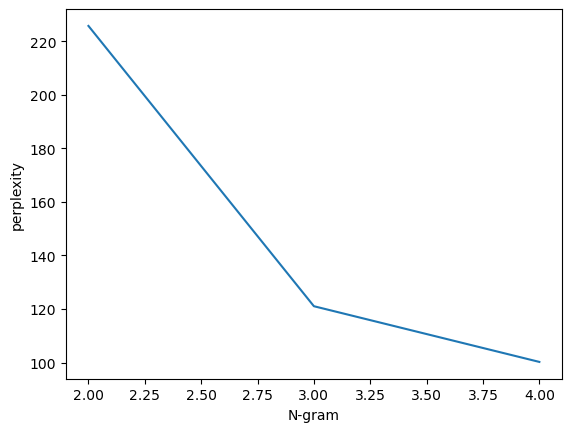

In [27]:
import matplotlib.pyplot as plt
plt.plot([2, 3, 4],perplexity)
plt.xlabel('N-gram')
plt.ylabel('perplexity')

- **Generate sentences from ngram LMs**

In [47]:
import re

def detok_wordpiece(sentence):
    """
    Merge WordPiece tokens: 'play', '##ing' -> 'playing'
    Keep punctuation tight-ish.
    """
    out = []
    tokens = sentence.split(" ")
    for t in tokens:
        if t.startswith("##") and out:
            out[-1] = out[-1] + t[2:]
        else:
            out.append(t)

    text = " ".join(out)

    # optional cleanup rules (lightweight)
    text = re.sub(r"\s+([.,!?;:%\)\]\}])", r"\1", text)   # remove space before punctuation
    text = re.sub(r"([\(\[\{])\s+", r"\1", text)          # remove space after opening bracket
    text = re.sub(r"\s+'", "'", text)                     # space before apostrophe
    text = re.sub(r"``\s*", '"', text)
    text = re.sub(r"\s*''", '"', text)
    return text
    
def ngram_generate(model, vocab, prompt, rand_seed, k, max_words):
    random.seed(rand_seed)
    sentence = ''
    state_in, state_out = kenlm.State(), kenlm.State()
    total_score = 0.0
    model.BeginSentenceWrite(state_in)
    selected_next_word = prompt
    count = 0
    while count < max_words:
        sentence += ' ' + selected_next_word
        sentence = sentence.strip()
        total_score += model.BaseScore(state_in, sentence, state_out)
        candidates = list((model.score(sentence + ' ' + next_word), next_word) for next_word in vocab)
        top_words = sorted(candidates, key=lambda item: item[0], reverse=True)
        selected_next_word = top_words[random.randint(0, k)][1]
        state_in, state_out = state_out, state_in
        count += 1
    return detok_wordpiece(sentence)

In [48]:
tok = Tokenizer.from_file("wikitext103_bpe_tokenizer.json")
vocab = tok.get_vocab()   # dict: token -> id
print(len(vocab))
vocab = set([_[0] for _ in vocab.items()])

50000


In [49]:
import random

for i in range(3):
    for n, model in zip([2,3,4], [gram2_model, gram3_model, gram4_model]):
        sentence = ngram_generate(model, vocab, "this is", rand_seed=i*4 + n, k=50, max_words=20)
        print(f'{n}-gram: ', sentence)
    print('-'*40)

2-gram:  this is = Timeline of France winner (15203 and engineer Charles = 2015 Sports Hall is 10 oz
3-gram:  this is — win 4HB4 chassis include Dairy Training. 3Co Award voting " articles to
4-gram:  this is bir) Moran defeated 3pi † = 5C; SOFe Bible Soundtrack?
----------------------------------------
2-gram:  this is 5 record) by photographer David ". The Man 6 RAR characteristics common ground station CBE Records
3-gram:  this is the first team choice =) Creek, = 4: 23 remaining aircraft commander of billon Lewis
4-gram:  this is all black market organoet: 2006} 4 engine sootet = Herodotus states is likely
----------------------------------------
2-gram:  this is usually " that you hold. Obergiana? Donington: 43 years that? Illustrated #
3-gram:  this is SO? Sheil? You walk! Andria said Lewis x ∗?? Ors,
4-gram:  this is where Middleton / EP The Driver Unit Records. 1 / = * yuan @ toasting.
----------------------------------------


## 1. backpropagation

The following followed from Adnrej's [micrograd](https://github.com/karpathy/micrograd).

In [12]:
def f(x):
    return 3 * x ** 2. - 4. * x + 5

In [13]:
x = 3.
print(f"evaluating f at x={x} : {f(x=x)}")

evaluating f at x=3.0 : 20.0


- **Draw the curve of f**

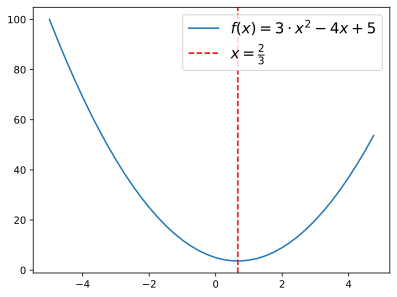

In [14]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys, label = r"$f(x) = 3 \cdot x^2 - 4 x + 5$")
plt.axvline(x=2/3, color='r', linestyle='--', label=r'$x = \frac{2}{3}$')
plt.legend(fontsize=15)

- What is the devaritive of $f(x)$ at any point $x$. Recall that
  $$
  f^\prime (x) = \lim_{h\rightarrow 0} \frac{ f(x + h ) - f(x)}{h}.
  $$
  We can approximate $f^\prime {x}$ by the following approximation:
  $$
  f^\prime (x) \approx \frac{ f(x + \delta_h ) - f(x)}{\delta_h}, \text{where } \delta_h \text{ is small.}
  $$

In [15]:
h = 0.000001
x = 2 / 3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [16]:
# Tokenization visualization
import tiktoken

cl100k_tokenizer = tiktoken.get_encoding("cl100k_base")

text = "Don't you love 🤗 Transformers? We sure do."
token_ids = cl100k_tokenizer.encode(text)
token_strs = [cl100k_tokenizer.decode([tid]) for tid in token_ids]
print("Original text:", text)
print("\nToken IDs:", token_ids)
print("\nToken strings:", token_strs)

Original text: Don't you love 🤗 Transformers? We sure do.

Token IDs: [8161, 956, 499, 3021, 11410, 97, 245, 81632, 30, 1226, 2771, 656, 13]

Token strings: ['Don', "'t", ' you', ' love', ' �', '�', '�', ' Transformers', '?', ' We', ' sure', ' do', '.']


In [17]:
# Prepare tokenization visualization (hidden in slideshow)
from IPython.display import HTML
import html

# Prepare the data
text = "Don't you love 🤗 Transformers? We sure do."
token_ids = cl100k_tokenizer.encode(text)
token_strs = [cl100k_tokenizer.decode([tid]) for tid in token_ids]

# Create HTML content
html_content = f"""
<div id="tokenization-viz" style="font-family: 'Courier New', monospace; margin: 20px 0;">
    <style>
        .token-grid {{
            display: grid;
            grid-template-rows: auto auto auto;
            gap: 25px;
            padding: 25px;
            background: linear-gradient(135deg, #f5f7fa 0%, #c3cfe2 100%);
            border-radius: 15px;
            max-width: 100%;
            overflow-x: auto;
            box-shadow: 0 4px 6px rgba(0,0,0,0.1);
        }}
        .token-row {{
            display: flex;
            flex-wrap: wrap;
            align-items: center;
            gap: 8px;
        }}
        .token-row-label {{
            font-weight: bold;
            margin-right: 20px;
            min-width: 140px;
            color: #2c3e50;
            font-size: 18px;
        }}
        .text-char {{
            padding: 10px 14px;
            background: #e3f2fd;
            border: 2px solid #2196F3;
            border-radius: 8px;
            font-size: 18px;
            white-space: pre;
            display: inline-block;
            margin: 3px;
            font-weight: 500;
            box-shadow: 0 2px 4px rgba(33, 150, 243, 0.3);
        }}
        .token-box {{
            padding: 10px 14px;
            background: #fff3e0;
            border: 2px solid #ff9800;
            border-radius: 8px;
            font-size: 15px;
            display: inline-block;
            margin: 3px;
            font-weight: 600;
            color: #e65100;
            box-shadow: 0 2px 4px rgba(255, 152, 0, 0.3);
            min-width: 50px;
            text-align: center;
        }}
        .token-string-box {{
            padding: 10px 14px;
            background: #e8f5e9;
            border: 2px solid #4caf50;
            border-radius: 8px;
            font-size: 18px;
            display: inline-block;
            margin: 3px;
            white-space: pre;
            font-weight: 500;
            box-shadow: 0 2px 4px rgba(76, 175, 80, 0.3);
        }}
        .row-1 .text-char {{
            animation: fadeIn 0.6s ease-in;
        }}
        .row-2 .token-box {{
            animation: fadeIn 0.6s ease-in;
            opacity: 0;
        }}
        .row-3 .token-string-box {{
            animation: fadeIn 0.6s ease-in;
            opacity: 0;
        }}
        @keyframes fadeIn {{
            from {{
                opacity: 0;
                transform: translateY(-15px) scale(0.95);
            }}
            to {{
                opacity: 1;
                transform: translateY(0) scale(1);
            }}
        }}
        /* Reveal.js fragment support */
        .fragment.current-visible .token-box,
        .fragment.current-visible .token-string-box {{
            opacity: 1 !important;
        }}
    </style>
    
    <div class="token-grid">
        <div class="token-row row-1 fragment">
            <span class="token-row-label">📝 Original Text:</span>
            <span class="text-char">{html.escape(text)}</span>
        </div>
        <div class="token-row row-2 fragment">
            <span class="token-row-label">🔢 Token IDs:</span>
            {' '.join([f'<span class="token-box">{tid}</span>' for tid in token_ids])}
        </div>
        <div class="token-row row-3 fragment">
            <span class="token-row-label">🔤 Token Strings:</span>
            {' '.join([f'<span class="token-string-box" title="Token ID: {tid}">{html.escape(ts)}</span>' for tid, ts in zip(token_ids, token_strs)])}
        </div>
    </div>
</div>

<script>
(function() {{
    // Wait for reveal.js to be available
    function initRevealAnimations() {{
        if (typeof Reveal !== 'undefined') {{
            // Animate tokens when slide becomes visible
            Reveal.addEventListener('slidechanged', function(event) {{
                const viz = event.currentSlide.querySelector('#tokenization-viz');
                if (viz) {{
                    // Reset and animate
                    const boxes = viz.querySelectorAll('.token-box, .token-string-box');
                    boxes.forEach((box, index) => {{
                        box.style.opacity = '0';
                        setTimeout(() => {{
                            box.style.animation = 'none';
                            setTimeout(() => {{
                                box.style.animation = 'fadeIn 0.6s ease-in';
                                box.style.opacity = '1';
                            }}, 10);
                        }}, index * 100);
                    }});
                }}
            }});
            
            // Also animate on fragments
            Reveal.addEventListener('fragmentshown', function(event) {{
                const boxes = event.fragment.querySelectorAll('.token-box, .token-string-box');
                boxes.forEach((box, index) => {{
                    setTimeout(() => {{
                        box.style.opacity = '1';
                    }}, index * 80);
                }});
            }});
        }} else {{
            // Fallback if reveal.js not loaded yet
            setTimeout(initRevealAnimations, 100);
        }}
    }}
    initRevealAnimations();
}})();
</script>
"""

In [18]:
# Create visualization with reveal.js fragments and arrows
from IPython.display import HTML as HTML_display
import html

num_tokens = len(token_ids)

viz_html = HTML_display(f"""
<div id="tokenization-viz" style="font-family: 'Courier New', monospace;">
    <style>
        #tokenization-viz .token-grid {{
            display: grid;
            grid-template-columns: 160px repeat({num_tokens}, min-content);
            grid-template-rows: auto auto auto auto auto;
            gap: 10px 8px;
            padding: 30px;
            background: linear-gradient(135deg, #f5f7fa 0%, #c3cfe2 100%);
            border-radius: 15px;
            box-shadow: 0 4px 6px rgba(0,0,0,0.1);
            align-items: center;
            justify-items: stretch;
        }}
        
        /* Label column (first column) */
        #tokenization-viz .row-label {{
            grid-column: 1;
            font-weight: bold;
            color: #2c3e50;
            font-size: 18px;
            text-align: right;
            padding-right: 15px;
        }}
        
        /* Token cells in grid columns 2 onwards */
        #tokenization-viz .token-cell {{
            display: flex;
            justify-content: center;
            align-items: center;
            min-width: fit-content;
        }}
        
        /* Original Text Row */
        #tokenization-viz .row-0 {{
            grid-row: 1;
        }}
        #tokenization-viz .row-0 .text-full {{
            grid-column: 2 / -1;
            padding: 12px 16px;
            background: #e3f2fd;
            border: 2px solid #2196F3;
            border-radius: 8px;
            font-size: 18px;
            white-space: pre;
            font-weight: 500;
            box-shadow: 0 2px 4px rgba(33, 150, 243, 0.3);
            text-align: center;
            box-sizing: border-box;
        }}
        
        /* Arrow Row 1 */
        #tokenization-viz .row-1 {{
            grid-row: 2;
            height: 50px;
        }}
        #tokenization-viz .row-1.fragment {{
            visibility: visible !important;
        }}
        
        /* Token Strings Row */
        #tokenization-viz .row-2 {{
            grid-row: 3;
        }}
        #tokenization-viz .token-string-box {{
            padding: 12px 16px;
            background: #e8f5e9;
            border: 2px solid #4caf50;
            border-radius: 8px;
            font-size: 18px;
            white-space: pre;
            font-weight: 500;
            box-shadow: 0 2px 4px rgba(76, 175, 80, 0.3);
            width: fit-content;
            text-align: center;
            box-sizing: border-box;
        }}
        
        /* Arrow Row 2 */
        #tokenization-viz .row-3 {{
            grid-row: 4;
            height: 50px;
        }}
        #tokenization-viz .row-3.fragment {{
            visibility: visible !important;
        }}
        
        /* Token IDs Row */
        #tokenization-viz .row-4 {{
            grid-row: 5;
        }}
        #tokenization-viz .token-box {{
            padding: 12px 16px;
            background: #fff3e0;
            border: 2px solid #ff9800;
            border-radius: 8px;
            font-size: 16px;
            font-weight: 600;
            color: #e65100;
            box-shadow: 0 2px 4px rgba(255, 152, 0, 0.3);
            width: fit-content;
            text-align: center;
            box-sizing: border-box;
        }}
        
        /* Arrow SVG styling */
        #tokenization-viz .arrow-svg {{
            width: 40px;
            height: 50px;
            opacity: 0;
            transition: opacity 0.6s ease-in;
            flex-shrink: 0;
        }}
        #tokenization-viz .row-1.visible .arrow-svg,
        #tokenization-viz .row-1.current-fragment .arrow-svg,
        #tokenization-viz .row-3.visible .arrow-svg,
        #tokenization-viz .row-3.current-fragment .arrow-svg {{
            opacity: 1;
        }}
        #tokenization-viz .arrow-svg path {{
            fill: none;
            stroke-linecap: round;
            stroke-linejoin: round;
        }}
    </style>
    
    <div class="token-grid">
        <!-- Row 0: Original Text -->
        <div class="row-label row-0 fragment" data-fragment-index="0">📝 Original Text:</div>
        <div class="text-full row-0 fragment" data-fragment-index="0">{html.escape(text)}</div>
        
        <!-- Row 1: Arrows from Original Text to Token Strings -->
        <div class="row-label row-1 fragment" data-fragment-index="1"></div>
        {' '.join([f'<div class="token-cell row-1 fragment" data-fragment-index="1"><svg class="arrow-svg" viewBox="0 0 40 50" preserveAspectRatio="xMidYMin meet"><path d="M20 0 L20 40 M12 33 L20 40 L28 33" stroke="#2196F3" stroke-width="2.5" fill="none" stroke-linecap="round" stroke-linejoin="round"/></svg></div>' for i in range(num_tokens)])}
        
        <!-- Row 2: Token Strings -->
        <div class="row-label row-2 fragment" data-fragment-index="2">🔤 Token Strings:</div>
        {' '.join([f'<div class="token-cell row-2 fragment" data-fragment-index="2"><span class="token-string-box" data-token-idx="{i}">{html.escape(ts)}</span></div>' for i, ts in enumerate(token_strs)])}
        
        <!-- Row 3: Arrows from Token Strings to Token IDs -->
        <div class="row-label row-3 fragment" data-fragment-index="3"></div>
        {' '.join([f'<div class="token-cell row-3 fragment" data-fragment-index="3"><svg class="arrow-svg" viewBox="0 0 40 50" preserveAspectRatio="xMidYMin meet"><path d="M20 0 L20 40 M12 33 L20 40 L28 33" stroke="#4caf50" stroke-width="2.5" fill="none" stroke-linecap="round" stroke-linejoin="round"/></svg></div>' for i in range(num_tokens)])}
        
        <!-- Row 4: Token IDs -->
        <div class="row-label row-4 fragment" data-fragment-index="4">🔢 Token IDs:</div>
        {' '.join([f'<div class="token-cell row-4 fragment" data-fragment-index="4"><span class="token-box" data-token-idx="{i}" title="{html.escape(ts)}">{tid}</span></div>' for i, (tid, ts) in enumerate(zip(token_ids, token_strs))])}
    </div>
</div>

<script>
(function() {{
    function initReveal() {{
        if (typeof Reveal !== 'undefined') {{
            Reveal.sync();
            
            // Function to animate arrows in a row
            function animateArrows(rowNum) {{
                const currentSlide = Reveal.getCurrentSlide();
                if (!currentSlide) return;
                
                const arrowCells = currentSlide.querySelectorAll(`#tokenization-viz .row-${{rowNum}}.visible .arrow-svg, #tokenization-viz .row-${{rowNum}}.current-fragment .arrow-svg`);
                arrowCells.forEach((arrow, idx) => {{
                    setTimeout(() => {{
                        arrow.style.opacity = '1';
                    }}, idx * 80);
                }});
            }}
            
            // Make arrows visible when their fragment is shown
            Reveal.addEventListener('fragmentshown', function(event) {{
                const fragment = event.fragment;
                const fragmentIndex = fragment.getAttribute('data-fragment-index');
                
                if (fragmentIndex === '1' || fragmentIndex === '3') {{
                    // Animate arrows one by one
                    const rowNum = fragmentIndex === '1' ? '1' : '3';
                    setTimeout(() => animateArrows(rowNum), 50);
                }}
            }});
            
            Reveal.addEventListener('fragmenthidden', function(event) {{
                const fragment = event.fragment;
                const fragmentIndex = fragment.getAttribute('data-fragment-index');
                
                if (fragmentIndex === '1' || fragmentIndex === '3') {{
                    const arrowCells = fragment.querySelectorAll('.arrow-svg');
                    arrowCells.forEach(arrow => {{
                        arrow.style.opacity = '0';
                    }});
                }}
            }});
            
            // Check current slide for visible arrow rows on slide change
            Reveal.addEventListener('slidechanged', function(event) {{
                setTimeout(() => {{
                    const currentSlide = Reveal.getCurrentSlide();
                    if (currentSlide) {{
                        // Check if arrow rows are visible
                        const row1 = currentSlide.querySelectorAll('#tokenization-viz .row-1.visible, #tokenization-viz .row-1.current-fragment');
                        const row3 = currentSlide.querySelectorAll('#tokenization-viz .row-3.visible, #tokenization-viz .row-3.current-fragment');
                        
                        if (row1.length > 0) animateArrows('1');
                        if (row3.length > 0) animateArrows('3');
                    }}
                }}, 100);
            }});
        }} else {{
            setTimeout(initReveal, 100);
        }}
    }}
    
    // Try to initialize immediately and also on load
    if (document.readyState === 'loading') {{
        document.addEventListener('DOMContentLoaded', initReveal);
    }} else {{
        initReveal();
    }}
}})();
</script>
""")

In [22]:
# Display the visualization (shown as slide)
# Make sure cells 10 and 11 have been executed first
from IPython.display import display

# Display the visualization created in cell 11
display(viz_html)